<a href="https://colab.research.google.com/github/CryptoRobotFr/easy_backtest/blob/main/cross_ema_secure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-binance ta

<h1> Récupération des données à partir de Binance <h1>

In [7]:
# Importation des librairies
import pandas as pd
from binance.client import Client
import ta
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Variables pour les données
client = Client()
pair_symbol = "ETHUSDT"
time_interval = Client.KLINE_INTERVAL_1HOUR
start_date = "01 january 2017"

# Récupération des données
klinesT = client.get_historical_klines(pair_symbol, time_interval, start_date)

# Créer un tableau grâce aux données
df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])

# Supprime les colonnes inutiles
df.drop(columns = df.columns.difference(['timestamp','open','high','low','close','volume']), inplace=True)

# Convertit les colonnes en numéric
for col in df.columns:
    df[col] = pd.to_numeric(df[col])

# Convertit les dates dans un format lisible
df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']

# Affiche le tableau
df

,open,high,low,close,volume
timestamp,,,,,
2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029
...,...,...,...,...,...
2022-04-02 05:00:00,3478.97,3484.95,3464.66,3481.02,10404.28340
2022-04-02 06:00:00,3481.03,3494.17,3471.55,3488.79,14214.63050
2022-04-02 07:00:00,3488.78,3496.17,3472.50,3484.64,17848.07590


<h1> Définition des indicateurs <h1>

In [8]:
# Ajout de nouvelle colonne dans le tableau représentant nos indicateurs
df['ema1'] = ta.trend.ema_indicator(close = df['close'], window = 25) # Moyenne exponentiel courte
df['ema2'] = ta.trend.ema_indicator(close = df['close'], window = 45) # Moyenne exponentiel moyenne
df['sma_long'] = ta.trend.sma_indicator(close = df['close'], window = 600) # Moyenne simple longue
df['stoch_rsi'] = ta.momentum.stochrsi(close = df['close'], window = 14) # Stochastic RSI non moyenné (K=1 sur Trading View)

# Affiche notre nouveau tableau
df

,open,high,low,close,volume,ema1,ema2,sma_long,stoch_rsi
timestamp,,,,,,,,,
2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246,NaN,NaN,NaN,NaN
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672,NaN,NaN,NaN,NaN
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510,NaN,NaN,NaN,NaN
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-04-02 05:00:00,3478.97,3484.95,3464.66,3481.02,10404.28340,3420.849409,3394.639986,2934.823967,0.172332
2022-04-02 06:00:00,3481.03,3494.17,3471.55,3488.79,14214.63050,3426.075609,3398.733465,2936.442950,0.287943
2022-04-02 07:00:00,3488.78,3496.17,3472.50,3484.64,17848.07590,3430.580562,3402.468532,2938.024250,0.168626


<h1>Backtest</h1>

In [9]:
initial_wallet = 1000 # Somme d'usd au début de la stratégie
taker_fee = 0.0007 # ~ 0.07% de frais sur binance et ftx 

# Condition pour rentrer en achat (row = période actuelle et previous_row = période précédente)
def buy_condition(row, previous_row = None):
    if row['ema1'] > row['ema2'] and row['stoch_rsi'] < 0.8 and row['close'] > row['sma_long']:
        return True
    else:
        return False

# Condition pour vendre (row = période actuelle et previous_row = période précédente)
def sell_condition(row, previous_row = None):
    if row['ema2'] > row['ema1'] and row['stoch_rsi'] > 0.2:
        return True
    else:
        return False

# Initalisation de notre portefeuille
wallet = initial_wallet
usd = initial_wallet
coin = 0

# Initialisation de nos tableaux qui vont contenir nos données d'analyse
trades_hitory = []
days_history = []
previous_day = 0

# Simulation de notre stratégie en parcourant notre tableau ligne par ligne
for index, row in df.iterrows():

    # Garde en mémoire l'évolution de notre portefeuille chaque jour pour pouvoir analyser plus tard
    current_day = index.day
    if previous_day != current_day:
        temp_wallet = wallet
        if coin > 0:
            temp_wallet = coin*row['close']
        days_history.append({
            "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
            "wallet":temp_wallet,
            "price":row['close']
        })
    previous_day = current_day

    # Vérifie les conditions si l'on doit acheter
    if buy_condition(row) and usd > 0:
        # Condition vérifiée, on achète à la clotûre
        coin = usd / row['close']           
        fee = taker_fee * coin             
        coin = coin - fee                   
        usd = 0                            
        wallet = coin * row['close']       
        # Ajout de données pour analyse future
        buy_data = {
            'date': index,
            'position': 'buy',
            'price': row['close'],
            'fee': fee * row['close'],
            'usd': usd,
            'coin': coin,
            'wallet': wallet
        }
        trades_hitory.append(buy_data) 

    # Vérifie les conditions si l'on doit vendre
    elif sell_condition(row) and  coin > 0:
        # Condition vérifiée, on vend à la clotûre
        usd = coin * row['close']          
        fee = taker_fee * usd               
        usd = usd - fee                     
        coin = 0                           
        wallet = usd                      
        # Ajout de données pour analyse future
        buy_data = {
            'date': index,
            'position': 'sell',
            'price': row['close'],
            'fee': fee,
            'usd': usd,
            'coin': coin,
            'wallet': wallet           
        }
        trades_hitory.append(buy_data) 

# Convertit en tableau exploitable les données récupérer lors de la simulation
df_days = pd.DataFrame(days_history)
df_days['day'] = pd.to_datetime(df_days['day'])
df_days = df_days.set_index(df_days['day'])

df_trades = pd.DataFrame(trades_hitory)
df_trades['date'] = pd.to_datetime(df_trades['date'])
df_trades = df_trades.set_index(df_trades['date'])

print("Backtest finished, ready for analysis...")

Backtest finished, ready for analysis...


Period: [2017-08-17 00:00:00] -> [2022-04-02 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 103759.97 $
Performance vs US dollar: 10276.0 %
Worst Drawdown : -33.89%
Buy and hold performance: 1064.2 %
Performance vs buy and hold: 791.26 %
Total trades on the period: 199
Global Win rate: 37.69 %
Average Profit: 2.96 %
Total fee: 8775.01 $

Best trades: +65.2 % the 2018-01-11 11:00:00
Worst trades: -9.9 % the 2020-05-10 07:00:00

--- Plot wallet evolution vs asset ---


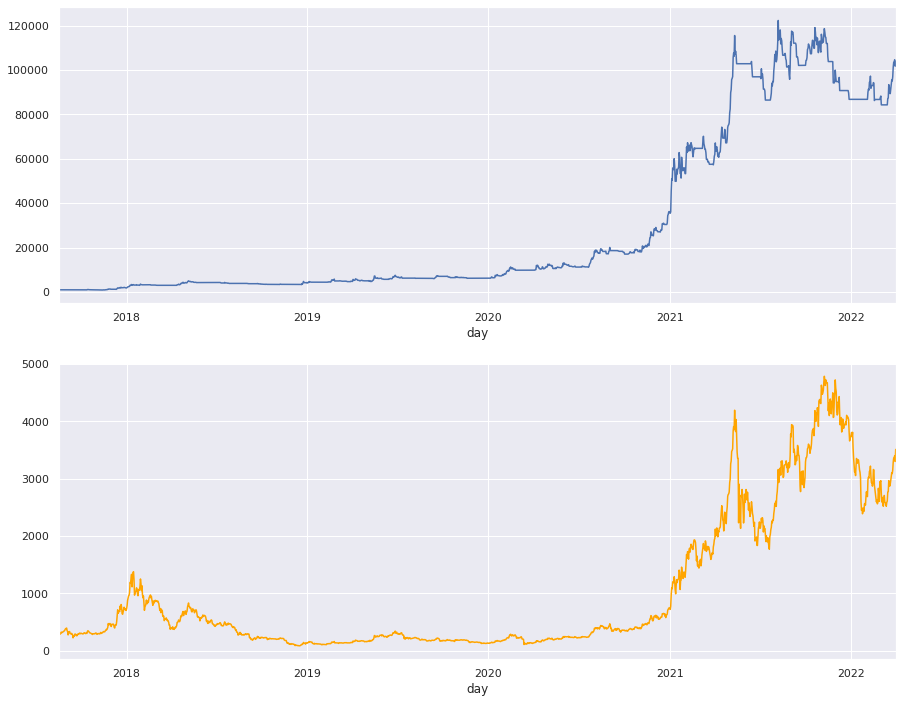

In [10]:
def plot_bar_by_month(df_days):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    custom_palette = {}
    
    last_month = int(df_days.iloc[-1]['day'].month)
    last_year = int(df_days.iloc[-1]['day'].year)
    
    current_month = int(df_days.iloc[0]['day'].month)
    current_year = int(df_days.iloc[0]['day'].year)
    current_year_array = []
    while current_year != last_year or current_month-1 != last_month:
        date_string = str(current_year) + "-" + str(current_month)
        
        monthly_perf = (df_days.loc[date_string]['wallet'].iloc[-1] - df_days.loc[date_string]['wallet'].iloc[0]) / df_days.loc[date_string]['wallet'].iloc[0]
        monthly_row = {
            'date': str(datetime.date(1900, current_month, 1).strftime('%B')),
            'result': round(monthly_perf*100)
        }
        if monthly_row["result"] >= 0:
            custom_palette[str(datetime.date(1900, current_month, 1).strftime('%B'))] = 'g'
        else:
            custom_palette[str(datetime.date(1900, current_month, 1).strftime('%B'))] = 'r'
        current_year_array.append(monthly_row)
        # print(monthly_perf*100) 
        if ((current_month == 12) or (current_month == last_month and current_year == last_year)):
            current_df = pd.DataFrame(current_year_array)
            # print(current_df)
            g = sns.barplot(data=current_df,x='date',y='result', palette=custom_palette)
            for index, row in current_df.iterrows():
                if row.result >= 0:
                    g.text(row.name,row.result, '+'+str(round(row.result))+'%', color='black', ha="center", va="bottom")
                else:
                    g.text(row.name,row.result, '-'+str(round(row.result))+'%', color='black', ha="center", va="top")
            g.set_title(str(current_year) + ' performance in %')
            g.set(xlabel=current_year, ylabel='performance %')
            
            year_result = (df_days.loc[str(current_year)]['wallet'].iloc[-1] - df_days.loc[str(current_year)]['wallet'].iloc[0]) / df_days.loc[str(current_year)]['wallet'].iloc[0]
            print("----- " + str(current_year) +" Cumulative Performances: " + str(round(year_result*100,2)) + "% -----")
            plt.show()

            current_year_array = []
        
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1

def plot_wallet_vs_asset(df_days):
    fig, axes = plt.subplots(figsize=(15, 12), nrows=2, ncols=1)
    df_days['wallet'].plot(ax=axes[0])
    df_days['price'].plot(ax=axes[1], color='orange')

def show_analys(days, trades):
    df_trades = trades.copy()
    df_days = days.copy()

    df_days['evolution'] = df_days['wallet'].diff()
    df_trades['trade_result'] = df_trades['wallet'].diff()
    df_trades['trade_result_pct'] = df_trades['wallet'].pct_change()

    df_days['wallet_ath'] = df_days['wallet'].cummax()
    df_days['drawdown'] = df_days['wallet_ath'] - df_days['wallet']
    df_days['drawdown_pct'] = df_days['drawdown'] / df_days['wallet_ath']

    initial_wallet = df_days.iloc[0]["wallet"]

    close_trades = df_trades.loc[df_trades['position'] == 'sell']
    good_trades = close_trades.loc[close_trades['trade_result_pct'] > 0]
    total_trades = len(close_trades)
    total_good_trades = len(good_trades)
    avg_profit = close_trades['trade_result_pct'].mean() 
    global_win_rate = total_good_trades / total_trades
    max_days_drawdown = df_days['drawdown_pct'].max()
    final_wallet = df_days.iloc[-1]['wallet']
    buy_and_hold_pct = (df_days.iloc[-1]['price'] - df_days.iloc[0]['price']) / df_days.iloc[0]['price']
    buy_and_hold_wallet = initial_wallet + initial_wallet * buy_and_hold_pct
    vs_hold_pct = (final_wallet - buy_and_hold_wallet)/buy_and_hold_wallet
    vs_usd_pct = (final_wallet - initial_wallet)/initial_wallet
    total_fee = df_trades['fee'].sum()

    best_trade = df_trades['trade_result_pct'].max()
    best_trade_date =  str(df_trades.loc[df_trades['trade_result_pct'] == best_trade].iloc[0]['date'])
    worst_trade = df_trades['trade_result_pct'].min()
    worst_trade_date =  str(df_trades.loc[df_trades['trade_result_pct'] == worst_trade].iloc[0]['date'])

    print("Period: [{}] -> [{}]".format(df_days.iloc[0]["day"], df_days.iloc[-1]["day"]))
    print("Initial wallet: {} $".format(round(initial_wallet,2)))

    print("\n--- General Information ---")
    print("Final wallet: {} $".format(round(final_wallet,2)))
    print("Performance vs US dollar: {} %".format(round(vs_usd_pct*100,2)))
    print("Worst Drawdown : -{}%".format(round(max_days_drawdown*100, 2)))
    print("Buy and hold performance: {} %".format(round(buy_and_hold_pct*100,2)))
    print("Performance vs buy and hold: {} %".format(round(vs_hold_pct*100,2)))
    print("Total trades on the period: {}".format(total_trades))
    print("Global Win rate: {} %".format(round(global_win_rate*100, 2)))
    print("Average Profit: {} %".format(round(avg_profit*100, 2)))
    print("Total fee: {} $".format(round(total_fee, 2)))

    print("\nBest trades: +{} % the {}".format(round(best_trade*100, 2), best_trade_date))
    print("Worst trades: {} % the {}".format(round(worst_trade*100, 2), worst_trade_date))

# Fonction pour afficher une analyse complète de la stratégie sur le passé
show_analys(df_days.loc[:], df_trades.loc[:])

print("\n--- Plot wallet evolution vs asset ---")
# Fonction pour afficher une analyse complète de la stratégie sur le passé
plot_wallet_vs_asset(df_days.loc[:])

----- 2017 Cumulative Performances: 82.96% -----


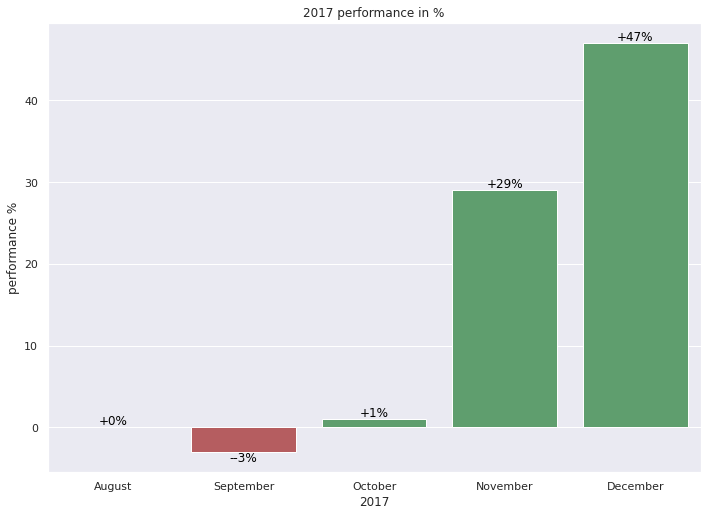

----- 2018 Cumulative Performances: 131.95% -----


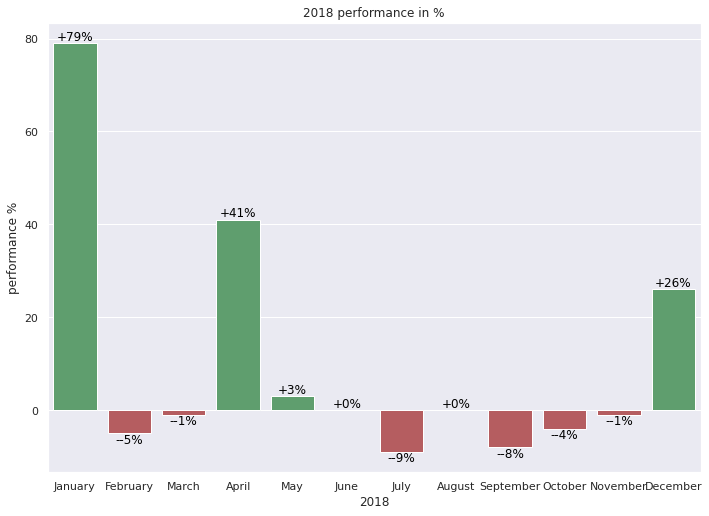

----- 2019 Cumulative Performances: 50.84% -----


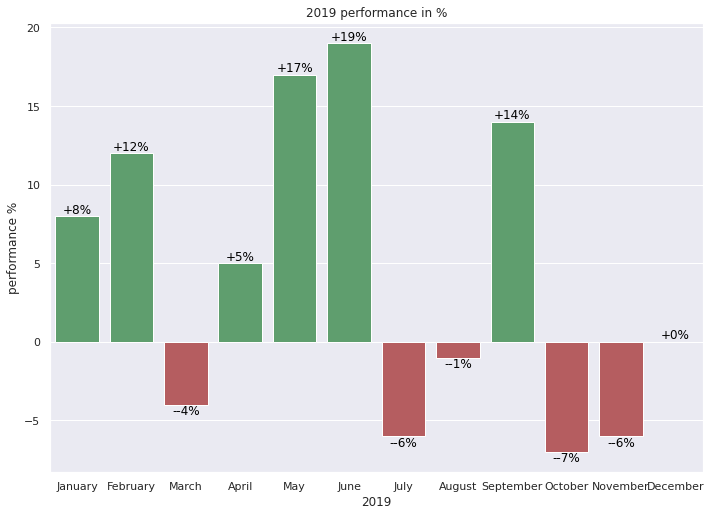

----- 2020 Cumulative Performances: 484.67% -----


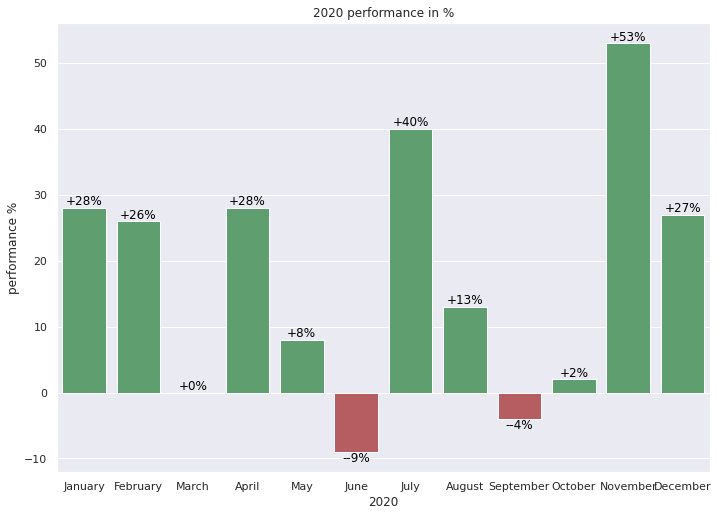

----- 2021 Cumulative Performances: 143.06% -----


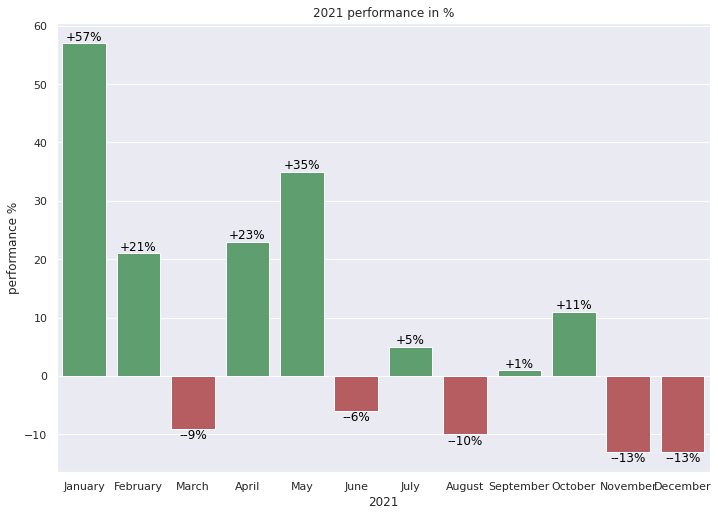

----- 2022 Cumulative Performances: 19.53% -----


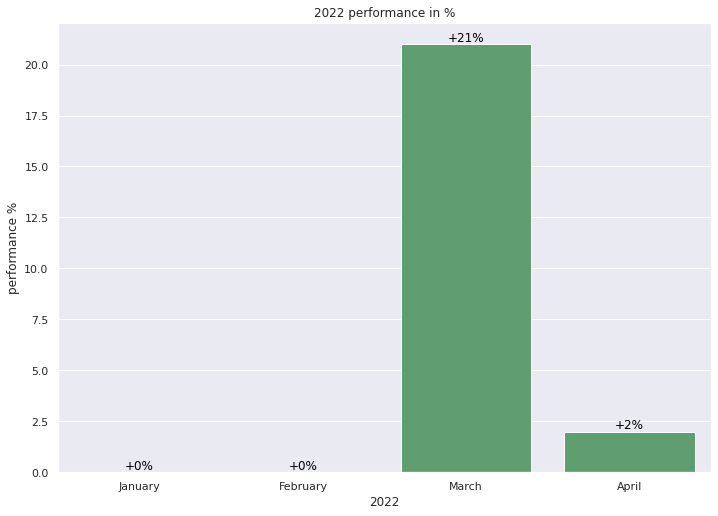

In [11]:
# Fonction pour afficher les gains et les pertes mois par mois
plot_bar_by_month(df_days.loc[:])